# Evaluate Model Notebook
## 1. Setup
### Import libraries

In [1]:
!pip install -qq bert-score rouge_score pycocoevalcap

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 16.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.9 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00

In [4]:
import os
import torch
import json
import numpy as np
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from bert_score import score as bert_score
from transformers import AutoModel, AutoTokenizer
from pycocoevalcap.cider.cider import Cider
from tabulate import tabulate
import pandas as pd

## 2. Define needed function for evaluation

In [5]:
def load_generated_captions(captions_file):
    captions_dict = {}
    with open(captions_file, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) != 2:
                print(f"Warning: Invalid line format in {captions_file}: {line.strip()}")
                continue
            img_name, caption = parts
            captions_dict[img_name] = caption.strip()
    return captions_dict

def load_gt_captions(captions_file):
    gt_captions = {}
    with open(captions_file, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) != 2:
                print(f"Warning: Invalid line format in {captions_file}: {line.strip()}")
                continue
            img_name, caption = parts
            if img_name not in gt_captions:
                gt_captions[img_name] = []
            gt_captions[img_name].append(caption.strip())
    return gt_captions

# Function to get n-grams from a string
def get_ngrams(text, n):
    tokens = text.split()
    return [' '.join(tokens[i:i+n]) for i in range(len(tokens)-n+1)]

# Function to debug common n-grams
def debug_ngrams(gts, hyp, max_n=4):
    for n in range(1, max_n+1):
        gts_ngrams = [get_ngrams(gt, n) for gt in gts]
        hyp_ngrams = get_ngrams(hyp, n)
        # Find common n-grams between the hypothesis and each ground truth
        # Note: We're looking for n-grams that appear in at least one GT and in the hypothesis
        common_ngrams = set()
        for gt_ngram_set in gts_ngrams:
            common_ngrams.update(set(gt_ngram_set).intersection(set(hyp_ngrams)))
        print(f"{n}-gram common: {common_ngrams}")

# Evaluation function
def evaluate_captions(generated_captions, gt_captions, dataset_name="Unknown"):
    bleu_scores = {f"BLEU-{i}": [] for i in range(1, 5)}
    rouge_l_scores = []
    bert_p_scores = []
    bert_r_scores = []
    bert_f1_scores = []
    all_gts = {}  # For CIDEr
    all_hyp = {}  # For CIDEr
    smoothing = SmoothingFunction().method1
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=False)
    cider_scorer = Cider()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize PhoBERT for BERTScore (Vietnamese language model)
    phobert = AutoModel.from_pretrained("vinai/phobert-base")
    tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
    from bert_score.utils import model2layers
    if "vinai/phobert-base" not in model2layers:
        model2layers["vinai/phobert-base"] = 12

    for idx, img_name in enumerate(tqdm(gt_captions.keys(), desc=f"Evaluating {dataset_name}")):
        if img_name not in generated_captions:
            print(f"Warning: No generated caption for {img_name}")
            continue
            
        ground_truths = gt_captions[img_name]  # List of reference captions
        generated_caption = generated_captions.get(img_name, "")
        generated_tokens = generated_caption.split()

        # Skip verbose printing for every image to improve performance
        # print(f"Image: {img_name}")
        # print(f"Generated Caption: {generated_caption}")
        # print(f"Ground Truth Captions: {ground_truths}")
        
        if not generated_caption.strip() or not any(gt.strip() for gt in ground_truths):
            print(f"Warning: Empty caption or ground truth detected for {img_name}!")
            continue
            
        # debug_ngrams(ground_truths, generated_caption)  # Comment out for performance

        # Store for CIDEr - properly format for multiple references
        all_gts[idx] = [gt for gt in ground_truths if gt.strip()]
        all_hyp[idx] = [generated_caption if generated_caption.strip() else ""]

        # BLEU-1 to BLEU-4 with multiple references
        reference_tokenized = [gt.split() for gt in ground_truths]
        for i in range(1, 5):
            weights = tuple(1.0/i if j < i else 0 for j in range(4))
            # Calculate BLEU against all references at once (not individually)
            bleu = sentence_bleu(
                reference_tokenized,  # Pass all references at once
                generated_tokens,
                weights=weights,
                smoothing_function=smoothing
            )
            bleu_scores[f"BLEU-{i}"].append(bleu)

        # ROUGE-L with best match among references
        best_rouge_l = 0.0
        for gt in ground_truths:
            rouge_scores = scorer.score(gt, generated_caption)
            best_rouge_l = max(best_rouge_l, rouge_scores['rougeL'].fmeasure)
        rouge_l_scores.append(best_rouge_l)

        # BERTScore with all references
        # bert-score package handles multiple references internally and returns the best scores
        P, R, F1 = bert_score(
            [generated_caption],  # Single hypothesis
            [ground_truths],      # List of references for one image
            model_type="vinai/phobert-base",
            lang="vi",
            device=device,
            use_fast_tokenizer=True,
            rescale_with_baseline=False
        )
        bert_p_scores.append(P.item())
        bert_r_scores.append(R.item())
        bert_f1_scores.append(F1.item())

    # Compute CIDEr
    try:
        cider_score, cider_scores_per_image = cider_scorer.compute_score(all_gts, all_hyp)
        cider_scores = list(cider_scores_per_image)
    except Exception as e:
        print(f"Error computing CIDEr: {e}")
        cider_scores = [0.0] * len(all_gts)

    # Compute average scores
    avg_bleu_scores = {f"BLEU-{i}": np.mean(bleu_scores[f"BLEU-{i}"]) for i in range(1, 5)}
    avg_rouge_l = np.mean(rouge_l_scores)
    avg_bert_p = np.mean(bert_p_scores)
    avg_bert_r = np.mean(bert_r_scores)
    avg_bert_f1 = np.mean(bert_f1_scores)
    avg_cider = np.mean(cider_scores)

    # Print results
    print(f"\nEvaluation Results for {dataset_name}:")
    for i in range(1, 5):
        print(f"Average BLEU-{i}: {avg_bleu_scores[f'BLEU-{i}']:.4f}")
    print(f"Average ROUGE-L: {avg_rouge_l:.4f}")
    print(f"Average BERTScore Precision: {avg_bert_p:.4f}")
    print(f"Average BERTScore Recall: {avg_bert_r:.4f}")
    print(f"Average BERTScore F1: {avg_bert_f1:.4f}")
    print(f"Average CIDEr: {avg_cider:.4f}")

    results = {
        **avg_bleu_scores,
        "ROUGE-L": avg_rouge_l,
        "BERTScore_P": avg_bert_p,
        "BERTScore_R": avg_bert_r,
        "BERTScore_F1": avg_bert_f1,
        "CIDEr": avg_cider
    }
    return results

def print_metrics_table(all_results: dict):
    """
    all_results: {dataset_name: {metric_name: value}}
    """
    # Gom thành DataFrame
    df = pd.DataFrame(all_results).T.round(4)

    # In đẹp bằng tabulate
    print("\n=== Comparison of Metrics ===")
    print(tabulate(df, headers="keys", tablefmt="fancy_grid"))


## 3. Evaluate ViT+T5 Image Captioning on Test Set

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Running on device: {device}")

# define datasets
datasets = [
    {
        "name": "capydata-ic",
        "gt_captions_file": "/kaggle/input/caption-dataset/ic_dataset/test/captions.txt",
        "generated_captions_file": "/kaggle/input/testmodel/scratch_cap_1.txt"
    },
]

results = {}
for dataset in datasets:
    # Load captions
    generated_captions = load_generated_captions(dataset["generated_captions_file"])
    gt_captions = load_gt_captions(dataset["gt_captions_file"])
    
    # Evaluate
    results[dataset["name"]] = evaluate_captions(
        generated_captions, gt_captions, dataset["name"]
    )
    
# Compare results
print_metrics_table(results)

Running on device: cuda


config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

2025-08-24 09:31:49.717502: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756027910.060558      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756027910.155174      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]


Evaluating capydata-ic:  11%|█         | 30/279 [00:42<05:46,  1.39s/it]HTTP Error 429 thrown while requesting HEAD https://huggingface.co/vinai/phobert-base/resolve/main/tokenizer_config.json
Retrying in 1s [Retry 1/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/vinai/phobert-base/resolve/main/tokenizer_config.json
Retrying in 2s [Retry 2/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/vinai/phobert-base/resolve/main/tokenizer_config.json
Retrying in 4s [Retry 3/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/vinai/phobert-base/resolve/main/tokenizer_config.json
Retrying in 8s [Retry 4/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/vinai/phobert-base/resolve/main/tokenizer_config.json
Retrying in 8s [Retry 5/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/vinai/phobert-base/resolve/main/tokenizer_config.json
HTTP Error 429 thrown while requesting HEAD https://huggingfa


Evaluation Results for capydata-ic:
Average BLEU-1: 0.5676
Average BLEU-2: 0.3363
Average BLEU-3: 0.2009
Average BLEU-4: 0.1293
Average ROUGE-L: 0.4886
Average BERTScore Precision: 0.5943
Average BERTScore Recall: 0.5673
Average BERTScore F1: 0.5790
Average CIDEr: 0.3455

=== Comparison of Metrics ===
╒═════════════╤══════════╤══════════╤══════════╤══════════╤═══════════╤═══════════════╤═══════════════╤════════════════╤═════════╕
│             │   BLEU-1 │   BLEU-2 │   BLEU-3 │   BLEU-4 │   ROUGE-L │   BERTScore_P │   BERTScore_R │   BERTScore_F1 │   CIDEr │
╞═════════════╪══════════╪══════════╪══════════╪══════════╪═══════════╪═══════════════╪═══════════════╪════════════════╪═════════╡
│ capydata-ic │   0.5676 │   0.3363 │   0.2009 │   0.1293 │    0.4886 │        0.5943 │        0.5673 │          0.579 │  0.3455 │
╘═════════════╧══════════╧══════════╧══════════╧══════════╧═══════════╧═══════════════╧═══════════════╧════════════════╧═════════╛


### 4. Final results
<table>
  <thead>
    <tr>
      <th>Dataset</th>
      <th>BLEU-1</th>
      <th>BLEU-2</th>
      <th>BLEU-3</th>
      <th>BLEU-4</th>
      <th>ROUGE-L</th>
      <th>BERTScore_P</th>
      <th>BERTScore_R</th>
      <th>BERTScore_F1</th>
      <th>CIDEr</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>capydata-ic</td>
      <td>0.5676</td>
      <td>0.3363</td>
      <td>0.2009</td>
      <td>0.1293</td>
      <td>0.4886</td>
      <td>0.5943</td>
      <td>0.5673</td>
      <td>0.5790</td>
      <td>0.3455</td>
    </tr>
  </tbody>
</table>


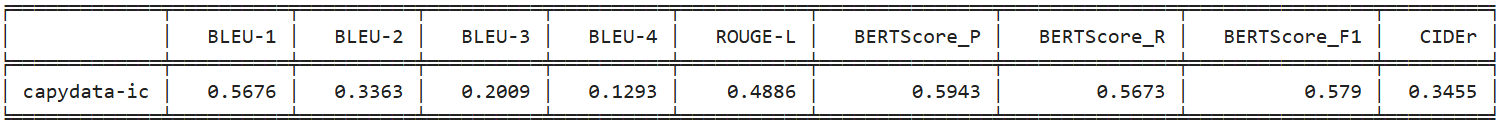